<a href="https://colab.research.google.com/github/brianfarrelly/final_capstone/blob/master/capstone_conv2d_4categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   What is the problem you are attempting to solve?

     Using machine learning/deep learning to analyze a set of chest xray 
     images and diagnose the presence of lung damage created by covid-19.
     It would also be useful to be able to train a model that would be 
     able to tell the difference between a normal chest x-ray and a 
     chest xray of an pneunomia affected patient. Pneunomia is also a  
     deadly lung disease. 


2.   How is your solution valuable?
     
     An automated tool that could assist a doctor, clinician or nurse 
     and tell them they are looking at a patient that has covid-19 lung   
     dammage is valuable. That patient can be isolated and immediately  
     start treatment. A different set of protocols are used with 
     patients that can be presumed covid-19 positive.  


3.   What is your data source and how will you access it? 

      The data is from 

      https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

      It consists of about 1.2 G of 5935 files of chest xray images. The 
      files have been copied over to my google drive and are accessed 
      from Google collab with access to the google drive mount.



4.   What techniques from the course do you anticipate using?

      The techniques used will be image processing with deep learning and 
      image processing with a CNN deep learning network. I will also try  
      to use Dask either locally on the google collab or with a remote 
      linux distro connected to by a local jupyter notebook running the 
      Dask client. 


5.   What do you anticipate to be the biggest challenge you’ll face? 
     
     The data is limited as far as the covid-19 positive training images. 
     I only have access to 58 of them in this dataset. So far my testing 
     with 3 categories of categorizing a normal dataset versus a 
     pneunomia dataset versus the covid-19 dataset. It would be nice to 
     be able to compare and categorize 1000 normal chest xray images, 
     versus 1000 penunomia xrays versus 1000 covid-19 images. That would 
     make the categorization training fair and not create imabalanced 
     results.    









Below is an initial notebook using a deep learning network to categorize 50 normal chest xrays versus 50 covid-19 chest xrays. I want to compare this loading more xrays to compare normal chest xrays versus a viral pneunomia infection versus a bacteria chest infection. I also want to compare using a flat neural network versus a convolution neural network. And see how much accuracy could be derived from other neural networks.


In [0]:
import h5py
from skimage import measure
from plotly.offline import iplot
from plotly import figure_factory as FF
import pandas as pd
import numpy as np
import string
from PIL import Image

import cv2

from cv2 import imshow

from google.colab.patches import cv2_imshow




In [124]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.2.0


In [125]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = '/content/gdrive/My Drive/data/corona/Chest_xray_Corona_dataset_Summary.csv'
corona = pd.read_csv(PATH)

In [0]:
PATH = '/content/gdrive/My Drive/data/corona/Chest_xray_Corona_Metadata.csv'
meta = pd.read_csv(PATH)



---



---



---



---



---



---



---



In [128]:
corona.head(20)

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [0]:
test = meta[meta.Dataset_type == 'TEST']

In [130]:
test.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5286,5309,IM-0021-0001.jpeg,Normal,TEST,NaN,NaN
5287,5310,IM-0019-0001.jpeg,Normal,TEST,NaN,NaN
5288,5311,IM-0017-0001.jpeg,Normal,TEST,NaN,NaN
5289,5312,IM-0016-0001.jpeg,Normal,TEST,NaN,NaN
5290,5313,IM-0015-0001.jpeg,Normal,TEST,NaN,NaN


In [131]:
test.Label.value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [0]:
train = meta[meta.Dataset_type == 'TRAIN']

In [0]:
train = train.fillna(0)

In [134]:
train.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,0,0
1,1,IM-0127-0001.jpeg,Normal,TRAIN,0,0
2,2,IM-0125-0001.jpeg,Normal,TRAIN,0,0
3,3,IM-0122-0001.jpeg,Normal,TRAIN,0,0
4,4,IM-0119-0001.jpeg,Normal,TRAIN,0,0


In [0]:
pnem = train[train.Label =='Pnemonia']

In [136]:
pnem.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
1341,1341,person101_virus_188.jpeg,Pnemonia,TRAIN,0,Virus
1342,1342,person101_virus_187.jpeg,Pnemonia,TRAIN,0,Virus
1343,1343,person1019_virus_1708.jpeg,Pnemonia,TRAIN,0,Virus
1344,1344,person1019_virus_1707.jpeg,Pnemonia,TRAIN,0,Virus
1345,1345,person1019_bacteria_2950.jpeg,Pnemonia,TRAIN,0,bacteria


In [137]:
pnem.shape

(3944, 6)

In [0]:
bac_pnem = pnem[pnem.Label_1_Virus_category == 'bacteria']

In [139]:
bac_pnem.shape

(2535, 6)

In [0]:
pnem = pnem[pnem.Label_2_Virus_category == 0]

In [141]:
pnem.shape

(3875, 6)

In [0]:
vir_pnem = pnem[pnem.Label_1_Virus_category == 'Virus']

In [143]:
vir_pnem.shape

(1345, 6)

In [144]:
covid = train[train.Label_2_Virus_category == 'COVID-19']
covid.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5221,5221,kjr-21-e25-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5222,5225,kjr-21-e24-g003-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5223,5228,kjr-21-e24-g002-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5224,5231,kjr-21-e24-g001-l-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5225,5234,jkms-35-e79-g001-l-c.jpg,Pnemonia,TRAIN,COVID-19,Virus


In [145]:
covid.shape

(58, 6)

In [146]:
norm = train[train.Label == 'Normal']
norm.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,0,0
1,1,IM-0127-0001.jpeg,Normal,TRAIN,0,0
2,2,IM-0125-0001.jpeg,Normal,TRAIN,0,0
3,3,IM-0122-0001.jpeg,Normal,TRAIN,0,0
4,4,IM-0119-0001.jpeg,Normal,TRAIN,0,0


In [147]:
norm.shape

(1342, 6)

In [148]:
fp = '/content/gdrive/My Drive/data/corona/train/IM-0147-0001.jpeg'
img = cv2.imread(fp)
img.shape

(1974, 2102, 3)

In [149]:
rimg = cv2.resize(img, (800, 600))
rimg.shape

(600, 800, 3)



---



---



---

NORMAL CHEST XRAY

---



---



---



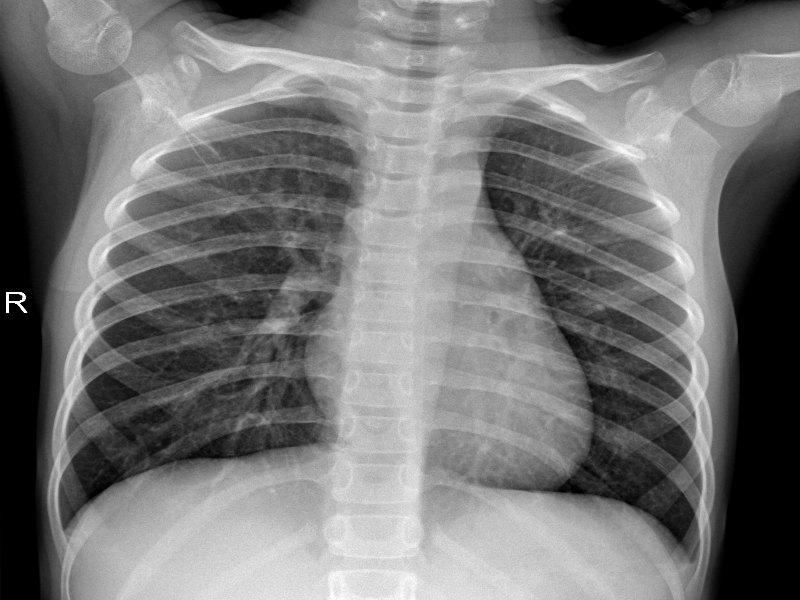

In [150]:
cv2_imshow(rimg)

In [151]:
fp = '/content/gdrive/My Drive/data/corona/train/2C10A413-AABE-4807-8CCE-6A2025594067.jpeg'
img = cv2.imread(fp)
img.shape

(3480, 4248, 3)

In [152]:
type(img)

numpy.ndarray

In [153]:
len(img[0])

4248

In [154]:
rimg = cv2.resize(img, (800, 600))
rimg.shape

(600, 800, 3)

In [155]:
type(rimg)

numpy.ndarray

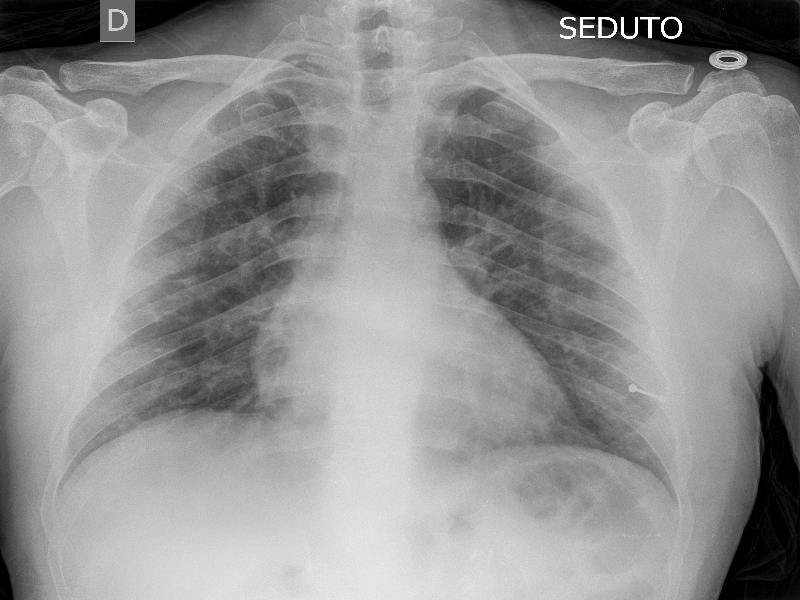

In [156]:
cv2_imshow(rimg)

In [157]:
norm.shape

(1342, 6)

In [158]:
bac_pnem.shape

(2535, 6)

In [159]:
vir_pnem.shape

(1345, 6)

In [160]:
covid.shape

(58, 6)

In [0]:
norm = norm.sample(1300)

In [0]:
bac_pnem = bac_pnem.sample(1300)

In [0]:
vir_pnem = vir_pnem.sample(1300)

In [0]:
covid = covid.sample(50)

In [164]:
X_train = []
Y_train = []

num = 0

for imgname in norm['X_ray_image_name']:
  path = "/content/gdrive/My Drive/data/corona/train/" + str(imgname)
  img = cv2.imread(path)
 
  
  rimg = cv2.resize(img, (200, 200))
  
  rimg = rimg / 255.0
  
  X_train.insert(0, rimg)
  Y_train.insert(0, 0)
  
  print(num)
  print(path)
  type(rimg)
  len(rimg)
  num += 1

  if(num>1299):
    break

0
/content/gdrive/My Drive/data/corona/train/IM-0538-0001.jpeg
1
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-0775-0001.jpeg
2
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-1365-0001.jpeg
3
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-1130-0001.jpeg
4
/content/gdrive/My Drive/data/corona/train/IM-0544-0001.jpeg
5
/content/gdrive/My Drive/data/corona/train/IM-0650-0001-0001.jpeg
6
/content/gdrive/My Drive/data/corona/train/IM-0228-0001.jpeg
7
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-0971-0001-0001.jpeg
8
/content/gdrive/My Drive/data/corona/train/IM-0427-0001.jpeg
9
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-0439-0001.jpeg
10
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-1341-0001.jpeg
11
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-1045-0001.jpeg
12
/content/gdrive/My Drive/data/corona/train/IM-0527-0001.jpeg
13
/content/gdrive/My Drive/data/corona/train/NORMAL2-IM-1102-0001.jpeg
14
/content/gdrive/My Drive/data/corona/

In [165]:
num = 0

for imgname in vir_pnem['X_ray_image_name']:
  path = "/content/gdrive/My Drive/data/corona/train/" + str(imgname)
  img = cv2.imread(path)
  
  rimg = cv2.resize(img, (200, 200))
    
  rimg = rimg / 255.0

  X_train.insert(0, rimg)
  Y_train.insert(0, 1)
  
  print(num)
  print(path)
  num += 1

  if(num>1299):
    break

0
/content/gdrive/My Drive/data/corona/train/person305_virus_627.jpeg
1
/content/gdrive/My Drive/data/corona/train/person1186_virus_2021.jpeg
2
/content/gdrive/My Drive/data/corona/train/person1188_virus_2024.jpeg
3
/content/gdrive/My Drive/data/corona/train/person409_virus_818.jpeg
4
/content/gdrive/My Drive/data/corona/train/person740_virus_1362.jpeg
5
/content/gdrive/My Drive/data/corona/train/person1142_virus_1892.jpeg
6
/content/gdrive/My Drive/data/corona/train/person116_virus_221.jpeg
7
/content/gdrive/My Drive/data/corona/train/person1177_virus_2001.jpeg
8
/content/gdrive/My Drive/data/corona/train/person1422_virus_2434.jpeg
9
/content/gdrive/My Drive/data/corona/train/person509_virus_1024.jpeg
10
/content/gdrive/My Drive/data/corona/train/person1202_virus_2045.jpeg
11
/content/gdrive/My Drive/data/corona/train/person1066_virus_1769.jpeg
12
/content/gdrive/My Drive/data/corona/train/person1079_virus_1789.jpeg
13
/content/gdrive/My Drive/data/corona/train/person457_virus_944.jpe

In [166]:
num = 0

for imgname in bac_pnem['X_ray_image_name']:
  path = "/content/gdrive/My Drive/data/corona/train/" + str(imgname)
  img = cv2.imread(path)
  
  rimg = cv2.resize(img, (200, 200))
    
  rimg = rimg / 255.0

  X_train.insert(0, rimg)
  Y_train.insert(0, 2)
  
  print(num)
  print(path)
  num += 1

  if(num>1299):
    break

0
/content/gdrive/My Drive/data/corona/train/person1323_bacteria_3361.jpeg
1
/content/gdrive/My Drive/data/corona/train/person1010_bacteria_2941.jpeg
2
/content/gdrive/My Drive/data/corona/train/person1418_bacteria_3637.jpeg
3
/content/gdrive/My Drive/data/corona/train/person40_bacteria_202.jpeg
4
/content/gdrive/My Drive/data/corona/train/person1292_bacteria_3255.jpeg
5
/content/gdrive/My Drive/data/corona/train/person26_bacteria_122.jpeg
6
/content/gdrive/My Drive/data/corona/train/person966_bacteria_2891.jpeg
7
/content/gdrive/My Drive/data/corona/train/person1728_bacteria_4556.jpeg
8
/content/gdrive/My Drive/data/corona/train/person385_bacteria_1766.jpeg
9
/content/gdrive/My Drive/data/corona/train/person475_bacteria_2020.jpeg
10
/content/gdrive/My Drive/data/corona/train/person548_bacteria_2302.jpeg
11
/content/gdrive/My Drive/data/corona/train/person573_bacteria_2369.jpeg
12
/content/gdrive/My Drive/data/corona/train/person1159_bacteria_3104.jpeg
13
/content/gdrive/My Drive/data/

In [88]:
num = 0

for imgname in covid['X_ray_image_name']:
  path = "/content/gdrive/My Drive/data/corona/train/" + str(imgname)
  img = cv2.imread(path)
  
 
  rimg = cv2.resize(img, (200, 200))
 
 
  rimg = rimg / 255.0

  X_train.insert(0, rimg)
  Y_train.insert(0, 3)
  
  print(num)
  print(path)
  num += 1

  if(num>49):
    break

0
/content/gdrive/My Drive/data/corona/train/E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg
1
/content/gdrive/My Drive/data/corona/train/jkms-35-e79-g001-l-a.jpg
2
/content/gdrive/My Drive/data/corona/train/1-s2.0-S1684118220300682-main.pdf-003-b2.png
3
/content/gdrive/My Drive/data/corona/train/1-s2.0-S1684118220300682-main.pdf-003-b1.png
4
/content/gdrive/My Drive/data/corona/train/31BA3780-2323-493F-8AED-62081B9C383B.jpeg
5
/content/gdrive/My Drive/data/corona/train/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg
6
/content/gdrive/My Drive/data/corona/train/4C4DEFD8-F55D-4588-AAD6-C59017F55966.jpeg
7
/content/gdrive/My Drive/data/corona/train/93FE0BB1-022D-4F24-9727-987A07975FFB.jpeg
8
/content/gdrive/My Drive/data/corona/train/kjr-21-e24-g003-l-a.jpg
9
/content/gdrive/My Drive/data/corona/train/7EF28E12-F628-4BEC-A8C5-E6277C2E4F60.png
10
/content/gdrive/My Drive/data/corona/train/5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg
11
/content/gdrive/My Drive/data/corona/train/35AF5C3B-D04D-4B4B-92B7-CB

In [167]:
type(X_train)

list

In [168]:
type(X_train[0])

numpy.ndarray

In [169]:
X_train[0].shape

(200, 200, 3)

In [170]:
len(Y_train)

3900

In [171]:
len(X_train)

3900




---



---



---


Save training data.
---



---



---



---





In [0]:
X_TRAIN_DATA = X_train.copy()
Y_TRAIN_DATA = Y_train.copy()

In [0]:
X_TRAIN = X_TRAIN_DATA.copy()
Y_TRAIN = Y_TRAIN_DATA.copy()

In [233]:
len(X_TRAIN)

3900

In [234]:
len(Y_TRAIN)

3900

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_TRAIN, Y_TRAIN, test_size = 0.2, random_state = 465)


In [236]:
len(X_train)

3120

In [237]:
len(y_train)

3120

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
#for element in dataset: 
#  print(element)

In [0]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [0]:
dataset = dataset.batch(80)

In [238]:
len(X_test)

780

In [239]:
len(y_test)

780

In [0]:
testset = tf.data.Dataset.from_tensor_slices((X_test, y_test)) 

In [0]:
type(testset)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [0]:
testset = testset.batch(20)

In [0]:
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [0]:
model = Sequential()
#model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))

model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(Conv2D(250,(3,3)))
model.add(Activation("relu"))
  
model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))
model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(AvgPool2D(2,2))

model.add(Conv2D(256,(2,2)))
model.add(Activation("relu"))
model.add(MaxPool2D(2,2))
    
model.add(Flatten())
model.add(Dense(32))
model.add(Dropout(0.25))
model.add(Dense(3))


In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


In [242]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 97, 97, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)       

In [0]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3))


In [189]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)       

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mae', 'sparse_categorical_accuracy'])


In [0]:
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


In [0]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test  = np.array(X_test)
y_test  = np.array(y_test)

In [192]:
history = model.fit(X_train, y_train, epochs=15, 
                    validation_data=(X_test, y_test))

Epoch 1/15
98/98 [==============================] - 3s 32ms/step - loss: 0.8265 - accuracy: 0.5981 - mae: 1.4738 - sparse_categorical_accuracy: 0.5981 - val_loss: 0.5330 - val_accuracy: 0.7692 - val_mae: 1.9119 - val_sparse_categorical_accuracy: 0.7692
Epoch 2/15
98/98 [==============================] - 3s 29ms/step - loss: 0.5363 - accuracy: 0.7561 - mae: 1.9101 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.4858 - val_accuracy: 0.7936 - val_mae: 1.8306 - val_sparse_categorical_accuracy: 0.7936
Epoch 3/15
98/98 [==============================] - 3s 29ms/step - loss: 0.4682 - accuracy: 0.7849 - mae: 2.2236 - sparse_categorical_accuracy: 0.7849 - val_loss: 0.4848 - val_accuracy: 0.8064 - val_mae: 1.8904 - val_sparse_categorical_accuracy: 0.8064
Epoch 4/15
98/98 [==============================] - 3s 29ms/step - loss: 0.4185 - accuracy: 0.8087 - mae: 2.5363 - sparse_categorical_accuracy: 0.8087 - val_loss: 0.4410 - val_accuracy: 0.8179 - val_mae: 2.7580 - val_sparse_categorical_accur

In [245]:
history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Train on 3120 samples, validate on 780 samples
Epoch 1/20
3120/3120 [==============================] - 6s 2ms/step - loss: 1.0997 - accuracy: 0.2946 - mae: 1.0214 - sparse_categorical_accuracy: 0.3410 - val_loss: 1.1012 - val_accuracy: 0.0000e+00 - val_mae: 1.0220 - val_sparse_categorical_accuracy: 0.3282
Epoch 2/20
3120/3120 [==============================] - 5s 2ms/step - loss: 1.1026 - accuracy: 0.2455 - mae: 1.0192 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.0988 - val_accuracy: 0.0000e+00 - val_mae: 1.0037 - val_sparse_categorical_accuracy: 0.3333
Epoch 3/20
3120/3120 [==============================] - 5s 2ms/step - loss: 1.0997 - accuracy: 0.4721 - mae: 1.0131 - sparse_categorical_accuracy: 0.3202 - val_loss: 1.0976 - val_accuracy: 1.0000 - val_mae: 1.0090 - val_sparse_categorical_accuracy: 0.3385
Epoch 4/20
3120/3120 [==============================] - 5s 2ms/step - loss: 1.0135 - accuracy: 0.3096 - mae: 1.1682 - sparse_categorical_accuracy: 0.4958 - val_loss: 0.9790 - va

In [246]:
 for x, y in history.history.items():
  print(x, y) 

val_loss [1.1012044026301457, 1.0988249913240091, 1.0976434444769836, 0.9790233819912642, 0.7625056398220551, 0.6883406232564877, 0.6936281950045855, 0.6378345333612883, 0.5811854279958285, 0.5959915356758313, 0.5572772047458551, 0.5491344296015226, 0.5257373265731029, 0.4999261580980741, 0.5230747751700573, 0.5016499993128655, 0.47987001217328584, 0.4869306206703186, 0.5242134140088008, 0.5133056075145037]
val_accuracy [0.0, 0.0, 1.0, 0.12435897439718246, 0.3102564215660095, 0.3346153795719147, 0.2846153974533081, 0.35256409645080566, 0.33205127716064453, 0.3589743673801422, 0.3384615480899811, 0.3282051384449005, 0.3589743673801422, 0.34487178921699524, 0.35384616255760193, 0.3512820601463318, 0.33974358439445496, 0.3294871747493744, 0.35384616255760193, 0.36282050609588623]
val_mae [1.021994948387146, 1.0037070512771606, 1.0089880228042603, 1.004814863204956, 1.1748141050338745, 1.3640280961990356, 1.3655154705047607, 1.5723543167114258, 1.6715587377548218, 1.8266324996948242, 2.067

In [248]:
score = model.evaluate(X_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

IndexError: ignored

In [0]:
result = model.predict_classes(X_train)

In [250]:
len(result)

3120

In [251]:
print(result)

[1 1 2 ... 2 1 1]


In [0]:
test = model.predict_classes(X_test)

In [253]:
len(test)

780

In [254]:
print(test)

[0 2 2 1 0 0 2 1 1 0 0 1 1 0 0 2 2 2 1 2 0 0 0 2 1 1 2 2 1 0 0 0 2 0 1 2 2
 2 0 0 1 2 0 0 0 0 2 0 2 0 2 1 1 1 1 0 0 0 1 2 1 2 1 2 1 1 0 1 1 2 2 2 1 1
 2 2 2 2 2 0 0 2 2 0 2 1 2 1 2 2 2 1 1 0 2 1 2 2 1 2 1 1 0 1 1 0 2 0 1 0 0
 2 0 2 2 0 0 2 1 2 2 1 1 0 0 0 1 2 1 1 0 1 2 0 0 0 1 2 1 0 0 2 0 0 0 1 1 2
 0 0 2 1 2 2 0 2 1 0 0 2 2 1 2 2 0 1 1 1 0 0 0 0 1 2 0 0 2 2 0 1 2 1 2 2 2
 0 1 0 0 1 0 2 0 0 2 2 1 0 2 0 0 1 0 1 0 1 2 2 1 1 0 1 1 1 0 0 2 2 1 0 1 1
 0 1 0 2 2 0 0 0 1 1 2 2 0 0 2 2 2 1 0 0 1 0 0 0 1 1 1 0 2 1 1 2 2 2 2 0 0
 0 1 1 1 2 1 0 2 2 2 2 0 0 1 2 1 2 2 2 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0
 2 0 1 0 2 0 0 1 0 2 0 2 2 1 2 2 0 2 0 0 1 0 1 2 1 2 2 1 0 2 1 2 0 1 2 2 2
 1 0 2 1 2 1 1 2 1 2 0 0 1 1 1 0 2 2 1 2 2 2 1 1 0 0 0 0 2 1 2 2 2 0 2 1 1
 0 1 1 1 0 2 1 2 0 2 1 1 2 2 1 1 2 0 0 2 0 2 1 0 2 1 1 0 0 0 0 0 2 0 1 2 2
 2 0 1 1 2 0 1 1 1 0 2 2 2 0 0 1 2 0 0 1 1 0 2 2 0 2 0 1 1 2 0 2 0 1 2 1 2
 2 2 1 0 0 0 2 2 1 1 0 1 2 2 2 0 0 0 0 0 2 0 0 2 1 1 0 0 2 0 2 2 2 0 0 1 0
 2 1 1 2 0 1 1 2 1 1 0 2 



---



---



---

Code Below is a possible confusion matrix plotted from the deep learning model.

---



---



---



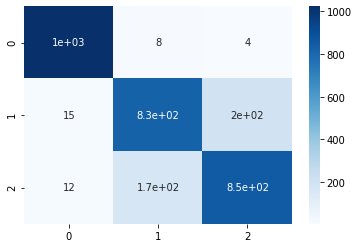

In [255]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_train, model.predict_classes(X_train))
sns.heatmap(cm, cmap='Blues', annot=True)


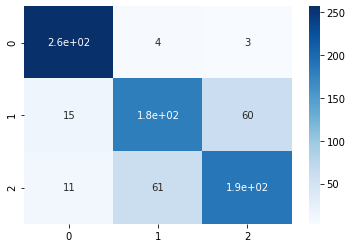

In [256]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, model.predict_classes(X_test))
sns.heatmap(cm, cmap='Blues', annot=True)





---



---



---



---



---



---



---



---

